## This page is under development...

I'm using yfinance package to download the stock data from yahoo finance. Then I will try predicting the prices for each stock. My goal is to make a prediction on the expected value and variance of the price based on the previous values. Then I'll try to compute the experimental covarience between different stocks and input them to an optimization problem designed to reduce the mixed variance while maximizing the expected output. This is based on the mean-volatility predicate in financial analysis.  
My initial intention was to use the rather new *tensorflow probability* capability to estimate the mean a variance for each output point. After some trials and failings, I have decided to use a simpler approach:
 - Use a small Nueral Net to compute a predicted value for the next days opening price for each stock.
 - Assume that my predictor assumes a normal distribution around the observed values (I should check this!). Therefore I can use the unbiased estimator of SD to find the expected variance around my predicted price.
 - Compute the correlations between different stocks experimentally (i.e. pairwise correlation between data columns)
 - perform the optimization as before.

In [308]:
import importlib
import single_stock_predictor
importlib.reload(single_stock_predictor)
import pickle
import yfinance as yf
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
#import mdn
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import minimize

%matplotlib notebook

If running for first time, you need to downloaded the stock symbols or "tickers". This is in done by setting parameter  "get_tickers".<br> Currently I'm downloading the daily data for 9years. If you already have downloaded some part of the data you can download the rest and append them to each other. Later I hope to automatize this section, since my goal is to run this script once weekly or so.

In [389]:
get_tickers = False 
read_tickers = True
get_histories = False
get_updated_data = False

In [390]:
def download_tickers():
    !curl -o /Users/abnousa/software/smartop/nasdaqtraded_companylist.txt ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt
    symbols = pd.read_csv("/Users/abnousa/software/smartop/nasdaqtraded_companylist.txt", sep = "|")
    symbols = symbols.iloc[0:(symbols.shape[0] - 1),:] #last row is time
    tickers = {}
    failed = []
    for i in symbols.index:
        sym = symbols.iloc[i]['Symbol']
        ticker = yf.Ticker(sym)
        try:
            check = ticker.calendar
        except Exception as e:
            print(' '.join(["disregarding", sym, type(e).__name__]))
            failed.append(sym)
            continue
        print(' '.join([sym, 'added']))
        name = symbols.iloc[i]['Security Name']
        tickers[sym] = {'name': name, 'ticker': ticker}
    sym_data = {'tickers':tickers, 'failed':failed}
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)
    return(sym_data)
if get_tickers:
    sym_data = download_tickers()

In [391]:
if read_tickers:
    with open('sym_data.pkl', 'rb') as symfile:
        sym_data = pickle.load(symfile)
        tickers, failed = sym_data['tickers'], sym_data['failed']

In [387]:
def download_histories(tickers):
    period = "9y"
    d = pd.DataFrame(data = 0, columns = list(tickers.keys()), index = temp_hist.index)
    d = download_ticker_histories(tickers, period = period, interval = "1d", columns = ['Open'])
    #with open("daily_history_9y.pkl", 'wb') as histfile:
    #    pickle.dump(d, histfile)
    return d
if get_histories:
    d = download_histories(sym_data['tickers'])

In [431]:
def download_ticker_histories(tickers, start = None, period = None, end = None, interval = "1d", columns = ['Open']):
    msft = yf.Ticker("MSFT")
    if start is None:
        temp_hist = msft.history(period="9y", interval="1d")
        end = list(temp_hist.index)[-1]
        start = list(temp_hist.index)[0]
    else:
        temp_hist = msft.history(start = start, interval = "1d")
        end = list(temp_hist.index)[-1]
    d = pd.DataFrame(data = 0, columns = list(tickers.keys()), index = temp_hist.index)
    for i in d.columns:
        print(i)
        hist = (tickers[i]['ticker'].history(start = start, end = end, interval = interval)[columns]).drop_duplicates(keep = 'last')
        d[i] = hist
    return d

In [432]:
with open("daily_history_9y.pkl", 'rb') as infile:
    d = pickle.load(infile)

In [433]:
def update_data(d, tickers, columns = ['Open']):
    last_date = (pd.to_datetime(d.index.values[-1])).strftime("%Y-%m-%d")
    d_update = download_ticker_histories(tickers, start = last_date, interval = "1d", columns = columns)
    d_update = d_update.iloc[1:,:]
    d_update.head()
    d_merged = pd.concat([d, d_update], axis = 0)
    return d_merged
if get_updated_data:
    d = update_data(d, tickers, columns = ['Open'])

A
AA
AAAU
AACG
AADR
AAL
AAMC
AAME
AAN
AAOI
AAON
AAP
AAPL
AAT
AAU
AAWW
AAXJ
AAXN
AB
ABB
ABBV
ABC
ABCB
ABDC
ABEO
ABEV
ABG
ABIL
ABIO
ABM
ABMD
ABR
ABT
ABTX
ABUS
AC
ACA
ACAD
ACAM
ACB
ACBI
ACC
ACCO
ACEL
ACER
ACES
ACH
ACHC
ACHN
ACHV
ACIA
ACIO
ACIU
ACIW
ACLS
ACM
ACMR
ACN
ACNB
ACOR
ACRE
ACRS
ACRX
ACSG
ACSI
ACST
ACT
ACTG
ACU
ACWF
ACWI
ACWV
ACWX
ACY
ADAP
ADBE
ADC
ADES
ADI
ADIL
ADM
ADMA
ADME
ADMP
ADMS
ADNT
ADP
ADPT
ADRA
ADRD
ADRE
ADRO
ADRU
ADS
ADSK
ADSW
ADT
ADTN
ADUS
ADVM
ADX
ADXS
AE
AEE
AEF
AEG
AEGN
AEHR
AEIS
AEL
AEM
AEMD
AEO
AEP
AER
AERI
AES
AESE
AEY
AEYE
AEZS
AFB
AFC
AFG
AFGE
AFH
AFI
AFIF
AFIN
AFINP
AFK
AFL
AFLG
AFMC
AFMD
AFSM
AFT
AFTY
AFYA
AG
AGBA
AGCO
AGD
AGE
AGEN
AGFS
AGG
AGGE
AGGP
AGGY
AGI
AGIO
AGLE
AGM
AGMH
AGN
AGNC
AGNCM
AGNCN
AGNCO
AGND
AGO
AGQ
AGR
AGRO
AGRX
AGS
AGT
AGTC
AGX
AGYS
AGZ
AGZD
AHC
AHCO
AHH
AHPI
AHT
AI
AIA
AIEQ
AIF
AIG
AIH
AIHS
AIIQ
AIM
AIMC
AIMT
AIN
AINC
AINV
AIQ
AIR
AIRG
AIRI
AIRR
AIRT
AIRTP
AIT
AIV
AIW
AIZ
AIZP
AJG
AJRD
AJX
AKAM
AKBA
AKCA
AKER
AKG
AKR
AKRO
AKRX
AKS
AKTS
AKT

DMRC
DMRE
DMRI
DMRL
DMRM
DMRS
DMTK
DNI
DNJR
DNKN
DNL
DNLI
DNN
DNOV
DNOW
DNP
DNR
DO
DOC
DOCU
DOG
DOGS
DOGZ
DOL
DOMO
DON
DOO
DOOO
DOOR
DORM
DOV
DOW
DOX
DOYU
DPHC
DPK
DPLO
DPST
DPW
DPZ
DQ
DRAD
DRADP
DRD
DRE
DRH
DRI
DRIO
DRIP
DRIV
DRN
DRNA
DRQ
DRR
DRRX
DRSK
DRTT
DRV
DRW
DS
DSGX
DSI
DSKE
DSLV
DSM
DSPG
DSS
DSSI
DSTL
DSU
DSWL
DSX
DT
DTD
DTE
DTEA
DTEC
DTF
DTH
DTIL
DTN
DTO
DTSS
DTUL
DTUS
DTYL
DTYS
DUC
DUG
DUK
DUO
DURA
DUSA
DUSL
DUST
DVA
DVAX
DVD
DVEM
DVHL
DVLU
DVN
DVOL
DVP
DVYA
DVYE
DVYL
DWAQ
DWAS
DWAT
DWCR
DWFI
DWIN
DWLD
DWM
DWMC
DWPP
DWSH
DWSN
DWT
DWTR
DWX
DX
DXC
DXCM
DXD
DXF
DXGE
DXJ
DXJS
DXLG
DXPE
DXR
DXYN
DY
DYAI
DYB
DYLS
DYNF
DYNT
DZK
DZSI
DZZ
E
EA
EAD
EAF
EAGG
EARN
EARS
EASG
EASI
EAST
EAT
EB
EBAY
EBF
EBIX
EBIZ
EBMT
EBND
EBR
EBS
EBSB
EBTC
EC
ECA
ECC
ECCA
ECCB
ECF
ECH
ECHO
ECL
ECLN
ECNS
ECOM
ECON
ECOR
ECOW
ECPG
ECT
ED
EDAP
EDC
EDEN
EDIT
EDIV
EDN
EDNT
EDOG
EDOW
EDRY
EDSA
EDTX
EDU
EDUC
EDV
EDZ
EE
EEA
EEB
EEFT
EEH
EEI
EELV
EEM
EEMA
EEMD
EEMO
EEMS
EEMV
EEMX
EES
EET
EEV
EEX
EFA
EFAD
EFAS
EFAV
E

IEZ
IFEU
IFF
IFGL
IFLY
IFMK
IFN
IFRA
IFRX
IFS
IFV
IG
IGA
IGBH
IGC
IGD
IGE
IGEB
IGF
IGHG
IGIB
IGIH
IGLB
IGM
IGMS
IGN
IGOV
IGR
IGRO
IGSB
IGT
IGV
IHAK
IHC
IHDG
IHE
IHF
IHG
IHI
IHRT
IHT
IHY
IHYD
IHYV
IIF
IIGD
IIGV
III
IIIN
IIIV
IIM
IIN
IIPR
IIVI
IJH
IJJ
IJK
IJR
IJS
IJT
IJUL
IKNX
ILF
ILMN
ILPT
ILTB
IMAC
IMAX
IMBI
IMFC
IMFD
IMFI
IMFP
IMGN
IMH
IMKTA
IMLP
IMMP
IMMR
IMMU
IMO
IMOM
IMOS
IMRN
IMTB
IMTE
IMTM
IMUX
IMV
IMXI
INAP
INBK
INCO
INCY
INDA
INDB
INDL
INDS
INDY
INFI
INFN
INFO
INFR
INFU
INFY
ING
INGN
INGR
INKM
INMB
INMD
INN
INNT
INO
INOD
INOV
INPX
INR
INS
INSE
INSG
INSI
INSM
INSP
INST
INSU
INSW
INT
INTC
INTF
INTG
INTL
INTT
INTU
INUV
INVA
INVE
INVH
INWK
INXN
IO
IONS
IOO
IOR
IOSP
IOTS
IOVA
IP
IPAC
IPAR
IPAY
IPDN
IPFF
IPG
IPGP
IPHA
IPHI
IPHS
IPI
IPKW
IPLDP
IPO
IPOS
IPWR
IQ
IQDE
IQDF
IQDG
IQDY
IQI
IQIN
IQLT
IQV
IR
IRBO
IRBT
IRCP
IRDM
IRET
IRIX
IRL
IRM
IRMD
IROQ
IRS
IRT
IRTC
IRWD
ISBC
ISCF
ISDR
ISDS
ISDX
ISEE
ISEM
ISG
ISHG
ISIG
ISMD
ISNS
ISR
ISRA
ISRG
ISSC
ISTB
ISTR
ISZE
IT
ITA
ITB
ITCB
ITCI
ITEQ
IT

PEG
PEGA
PEGI
PEI
PEIX
PEJ
PEK
PEN
PENN
PEO
PEP
PER
PERI
PESI
PETQ
PETS
PETZ
PEX
PEXL
PEY
PEZ
PFBC
PFBI
PFD
PFE
PFF
PFFA
PFFD
PFFL
PFFR
PFG
PFGC
PFI
PFIE
PFIG
PFIN
PFIS
PFL
PFLD
PFLT
PFM
PFMT
PFN
PFNX
PFO
PFPT
PFS
PFSI
PFSW
PFXF
PG
PGAL
PGC
PGF
PGHY
PGJ
PGM
PGNX
PGNY
PGP
PGR
PGRE
PGTI
PGX
PH
PHAS
PHAT
PHB
PHCF
PHD
PHDG
PHG
PHGE
PHI
PHIO
PHK
PHM
PHO
PHR
PHT
PHUN
PHX
PHYL
PI
PICB
PICK
PICO
PID
PIE
PIH
PIHPP
PII
PILL
PIM
PIN
PINC
PINE
PING
PINS
PIO
PIR
PIRS
PIXY
PIZ
PJAN
PJC
PJP
PJT
PJUL
PJUN
PK
PKB
PKBK
PKD
PKE
PKG
PKI
PKOH
PKW
PKX
PLAB
PLAG
PLAN
PLAT
PLAY
PLBC
PLC
PLCE
PLCY
PLD
PLG
PLIN
PLL
PLM
PLMR
PLNT
PLOW
PLPC
PLSE
PLT
PLTM
PLUG
PLUS
PLX
PLXP
PLXS
PLYA
PLYM
PM
PMBC
PMD
PME
PMF
PML
PMM
PMO
PMOM
PMR
PMT
PMTS
PMX
PNBK
PNC
PNF
PNFP
PNI
PNM
PNNT
PNOV
PNQI
PNR
PNRL
PNTG
PNW
POAI
POCT
PODD
POL
POLA
POOL
POPE
POR
POST
POTX
POWI
POWL
PPA
PPBI
PPC
PPDM
PPEM
PPG
PPH
PPHI
PPIH
PPL
PPLC
PPLN
PPLT
PPMC
PPR
PPSC
PPSI
PPT
PPTY
PQG
PQIN
PQLC
PQSG
PQSV
PRA
PRAA
PRAH
PRCP
PREF
PRF
PRFT
PRFZ
PRGO
PRGS


UBOT
UBP
UBR
UBS
UBSI
UBT
UBX
UCBI
UCC
UCFC
UCHF
UCI
UCIB
UCO
UCOM
UCON
UCTT
UDEC
UDN
UDOW
UE
UEC
UEIC
UEPS
UEUR
UEVM
UFAB
UFCS
UFI
UFO
UFPI
UFPT
UFS
UG
UGA
UGAZ
UGBP
UGE
UGI
UGL
UGLD
UGP
UHAL
UHS
UHT
UI
UIHC
UIS
UITB
UIVM
UJAN
UJB
UJPY
UJUL
UJUN
UL
ULBI
ULBR
ULE
ULH
ULST
ULTA
ULTR
ULVM
UMBF
UMC
UMDD
UMH
UMPQ
UMRX
UN
UNAM
UNB
UNF
UNFI
UNG
UNH
UNIT
UNL
UNM
UNOV
UNP
UNT
UNTY
UNVR
UOCT
UONEK
UPLD
UPRO
UPS
UPV
UPW
UPWK
URA
URBN
URE
URG
URGN
URI
URNM
UROV
URR
URTH
URTY
USA
USAC
USAI
USAK
USAP
USAS
USAU
USB
USCI
USCR
USD
USDP
USDU
USDY
USEG
USEP
USEQ
USFD
USFR
USHG
USHY
USI
USIG
USIO
USL
USLB
USLM
USLV
USM
USMC
USMF
USMV
USNA
USO
USOI
USPH
USRT
USSG
UST
USTB
USV
USVM
USWS
USX
UTES
UTF
UTG
UTHR
UTI
UTL
UTMD
UTRN
UTSI
UTSL
UTX
UUP
UUU
UUUU
UVE
UVSP
UVV
UVXY
UWM
UWT
UXI
UXIN
UYG
UYM
V
VAC
VAL
VALE
VALQ
VALT
VALU
VALX
VAMO
VAPO
VAR
VAW
VB
VBF
VBFC
VBIV
VBK
VBLT
VBND
VBR
VBTX
VC
VCEL
VCF
VCIT
VCLT
VCNX
VCR
VCRA
VCSH
VCTR
VCV
VCYT
VDC
VDE
VEA
VEC
VECO
VEDL
VEEV
VEGA
VEGI
VEGN
VEON
VER
VERB
VERI
VE

In [440]:
d = dp
d.head()

,A,AA,AAAU,AACG,AADR,AAL,AAMC,AAME,AAN,AAOI,...,ZSL,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-23,26.84,34.16,NaN,NaN,28.02,9.75,NaN,1.8205,19.52,NaN,...,111.8,NaN,4.49,NaN,28.40,NaN,NaN,NaN,NaN,0.34
2010-12-27,26.82,34.23,NaN,NaN,27.95,9.40,NaN,1.8482,19.50,NaN,...,110.5,NaN,4.52,NaN,28.50,NaN,NaN,NaN,NaN,0.32
2010-12-28,27.50,34.36,NaN,NaN,28.10,9.37,NaN,1.8482,19.78,NaN,...,106.4,NaN,4.53,NaN,28.91,NaN,NaN,NaN,NaN,0.31
2010-12-29,27.25,34.48,NaN,NaN,28.08,9.41,NaN,1.8482,19.59,NaN,...,100.9,NaN,4.52,NaN,28.69,NaN,NaN,NaN,NaN,0.30
2010-12-30,27.31,34.05,NaN,NaN,28.27,9.61,NaN,1.8667,19.71,NaN,...,99.6,NaN,4.52,NaN,28.10,NaN,NaN,NaN,NaN,0.32


In [441]:
d.tail()


,A,AA,AAAU,AACG,AADR,AAL,AAMC,AAME,AAN,AAOI,...,ZSL,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-27,85.50,21.41,15.08,1.45,54.57,29.76,13.19,1.90,57.05,11.67,...,26.66,23.27,11.41,133.40,33.15,14.40,2.10,45.00,5.79,8.02
2019-12-30,85.34,21.70,15.11,1.40,54.54,28.50,13.50,1.85,56.35,11.50,...,26.70,23.63,11.32,133.57,32.79,14.10,2.03,44.56,5.70,8.05
2019-12-31,84.84,21.37,15.19,1.37,54.35,28.20,11.22,1.93,56.65,11.56,...,26.90,23.29,11.40,132.01,33.93,14.05,2.04,44.90,5.78,7.84
2020-01-02,85.90,21.86,15.24,1.35,54.56,28.98,12.31,1.99,57.41,12.13,...,26.34,23.40,11.43,132.05,34.84,14.19,2.05,45.65,6.09,7.95
2020-01-03,84.67,21.17,15.45,1.36,54.36,28.27,14.48,1.77,57.08,12.25,...,26.04,23.23,11.39,132.48,33.75,14.56,2.00,47.00,5.80,7.81


(array([4166.,   28.,   26.,   48.,   21.,   23.,   20.,   10.,   23.,
          24.,   22.,    8.,   56.,   17.,   46.,   21.,   14.,   23.,
          17.,   24.,   34.,   11.,   16.,   27.,   21.,   30.,   29.,
          31.,   28.,   23.,   38.,   60.,   27.,   23.,   46.,   28.,
          41.,   41.,   53.,   40.,   24.,   44.,   44.,   34.,   31.,
          34.,   32.,   25.,   35.,   36.,   58.,   28.,   32.,   36.,
          38.,   29.,   16.,   20.,   25.,   36.,   39.,   28.,   25.,
          46.,   39.,   26.,   34.,   35.,   21.,   27.,   38.,   37.,
          62.,   28.,   30.,   57.,   89.,   50.,   45.,   40.,   48.,
          37.,   45.,   46.,   56.,   45.,   71.,   46.,   35.,   33.,
          25.,   66.,   59.,   44.,   38.,   38.,   20.,   57.,   47.,
          38.]),
 array([   0.  ,   22.64,   45.28,   67.92,   90.56,  113.2 ,  135.84,
         158.48,  181.12,  203.76,  226.4 ,  249.04,  271.68,  294.32,
         316.96,  339.6 ,  362.24,  384.88,  407.52,  430.16

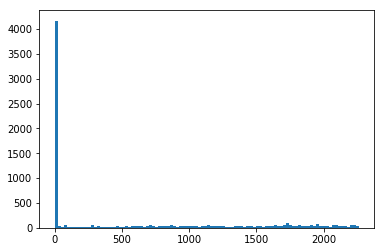

In [7]:
plt.hist(d.isna().sum(), bins = 100)

In [303]:
d = d.iloc[:, list(np.where(d.isna().sum() < 20)[0])]
d = d.fillna(method = "bfill")
d.shape

(2264, 4165)

In [305]:
stock_name = "MSFT"
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 20
training_points = 1500
sd_estimate_required = True
model_outdir = "models"
training_verbosity = 1
look_ahead_window = 5
pred, train_sd, train_forecasts, valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, sd_estimate_required = sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
46/46 [==============================] - 4s 81ms/step - loss: 517.4139 - val_loss: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 3.9455 - val_loss: 13.2277
Epoch 3/20
46/46 [==============================] - 1s 32ms/step - loss: 1.4690 - val_loss: 7.6193
Epoch 4/20
46/46 [==============================] - 1s 32ms/step - loss: 1.3611 - val_loss: 6.9233
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 1.4190 - val_loss: 7.5737
Epoch 6/20
4

<IPython.core.display.Javascript object>


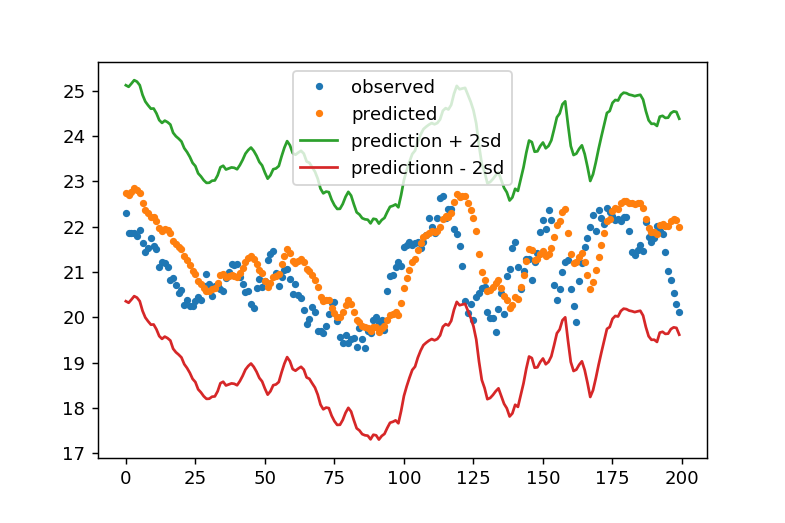

In [311]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


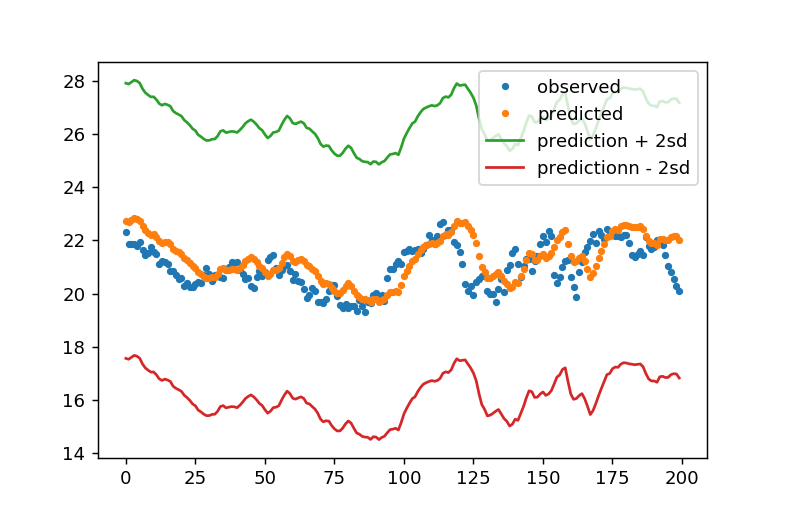

In [312]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


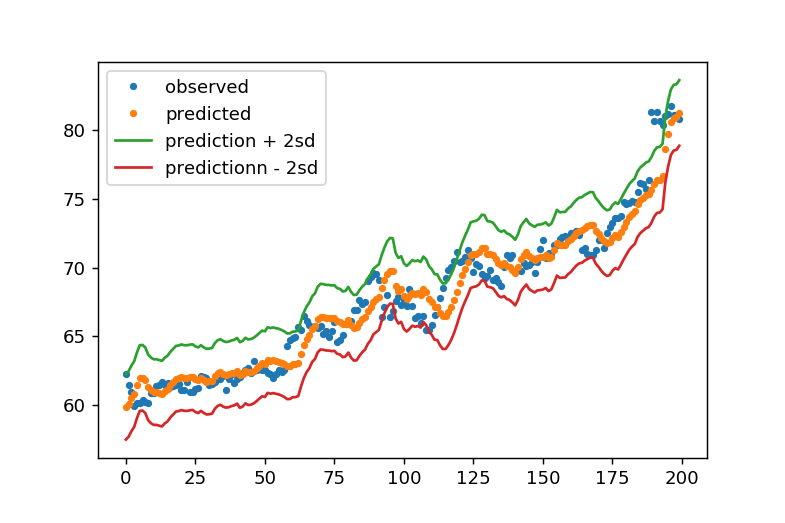

In [313]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


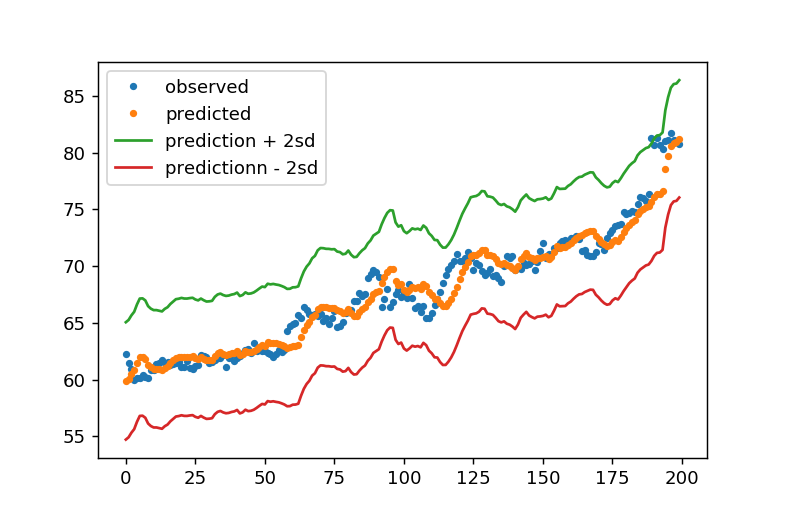

In [314]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

In [315]:
print(train_sd, valid_sd)

1.1910912795208732 2.585256363796105


okay, so far we have showed that for the specified stock (here, MSFT aka microsoft) our model generates rather dependable predictions of price and our estimated standard deviation seems to be fitting at least visually. Of course, one can argue that we have picked an easy ticker, you'd expect microsoft to have a stable price. Well, I can't argue against that. But now, I'm going to randomly pick 10 tickers and perform the same operation on each of them. Before that I
m going to use the *cov()* function from pandas to compute pairwise correlation between the selected tickers.

In [35]:
import random
ticker_set = random.sample(list(d.columns), 10)
ticker_set

['FLT', 'WAFD', 'SORL', 'NAVB', 'TRN', 'DBE', 'IYW', 'AMOV', 'OLP', 'RIGL']

In [49]:
d_select = d[ticker_set]
print(d_select.shape)
corels = d_select.corr()

(2264, 10)


(<matplotlib.image.AxesImage at 0x1bde6b7b8>,
 <matplotlib.colorbar.Colorbar at 0x1c7545dd8>)

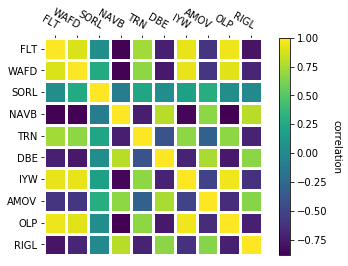

In [50]:
corels_matrix = np.array(corels)
heatmap(corels_matrix, corels.columns.values, corels.columns.values, cbarlabel = "correlation")

In [316]:
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 20
training_points = 1500
sd_estimate_required = True
model_outdir = "models"
training_verbosity = 0

In [321]:
prediction_dict = {}
for stock_name in ticker_set:
    print(" ".join(["processing", stock_name]))
    pred, train_sd, train_forecasts, valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, sd_estimate_required = sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)
    prediction_dict[stock_name] = {'expected_tomorrow': pred,
                                   'train_sd': train_sd,
                                   'train_forecasts': train_forecasts,
                                   'valid_sd': valid_sd,
                                   'valid_forecasts': valid_forecasts}
    current_price = d.iloc[d.shape[0]-1][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

processing FLT
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
processing WAFD
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_______________________________________________________________

It looks like for a few of the stocks, validation error was smaller than the training error. I'm curious why.

So here are the plots from validation data:

<IPython.core.display.Javascript object>


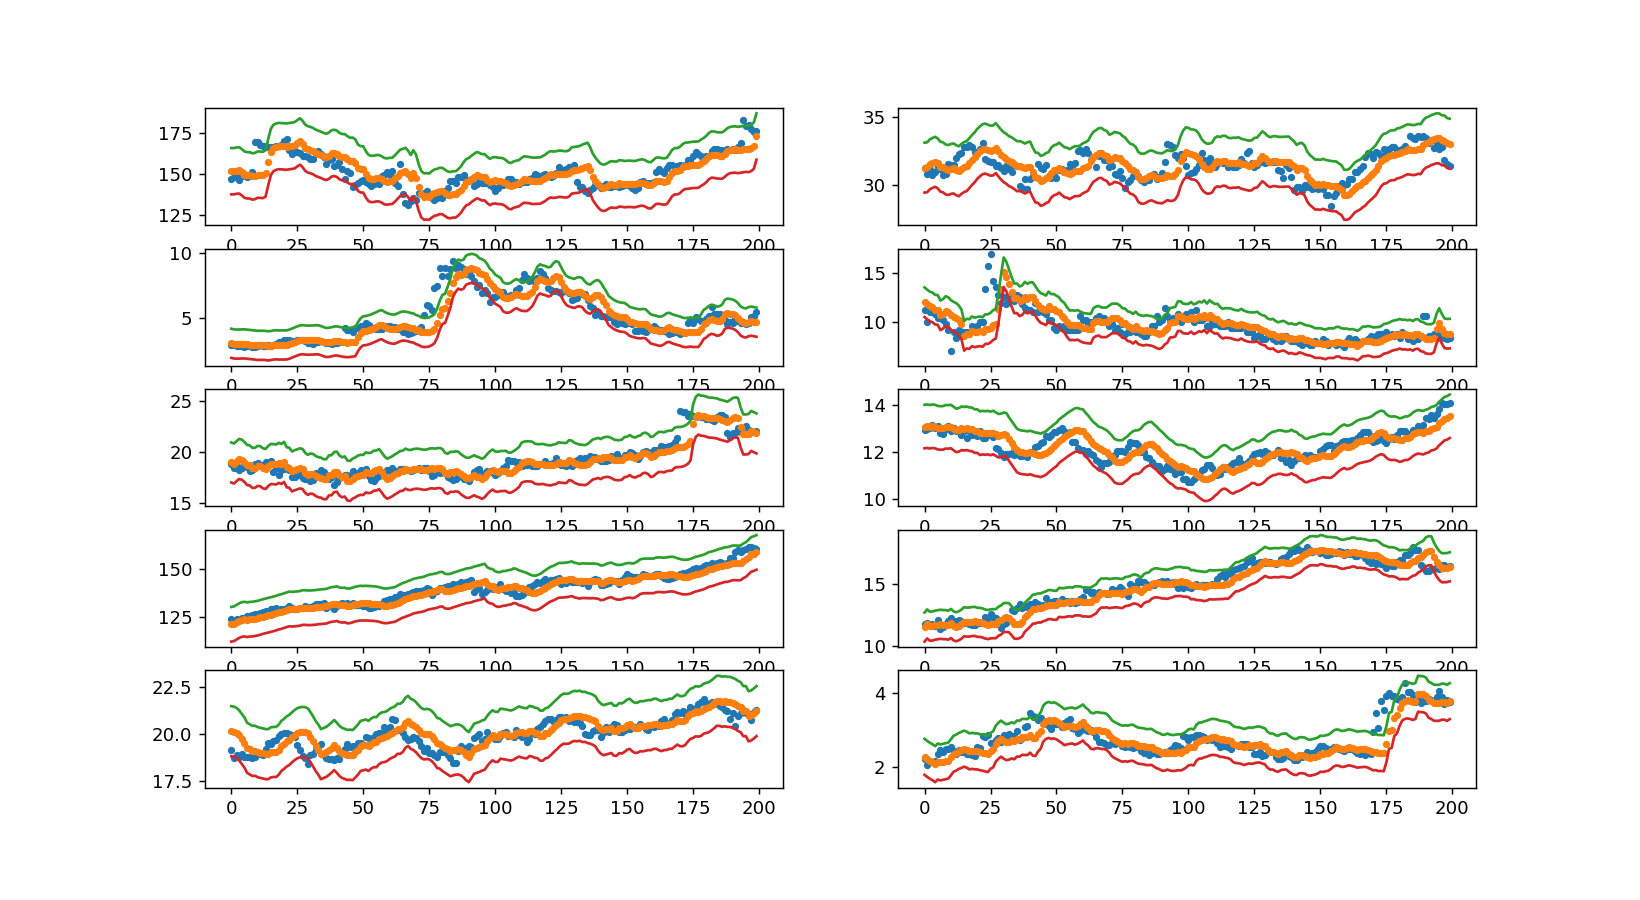

In [322]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name][training_points:], prediction_dict[stock_name]['valid_forecasts'], prediction_dict[stock_name]['valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)
    
            

and here are plots for training data:

<IPython.core.display.Javascript object>


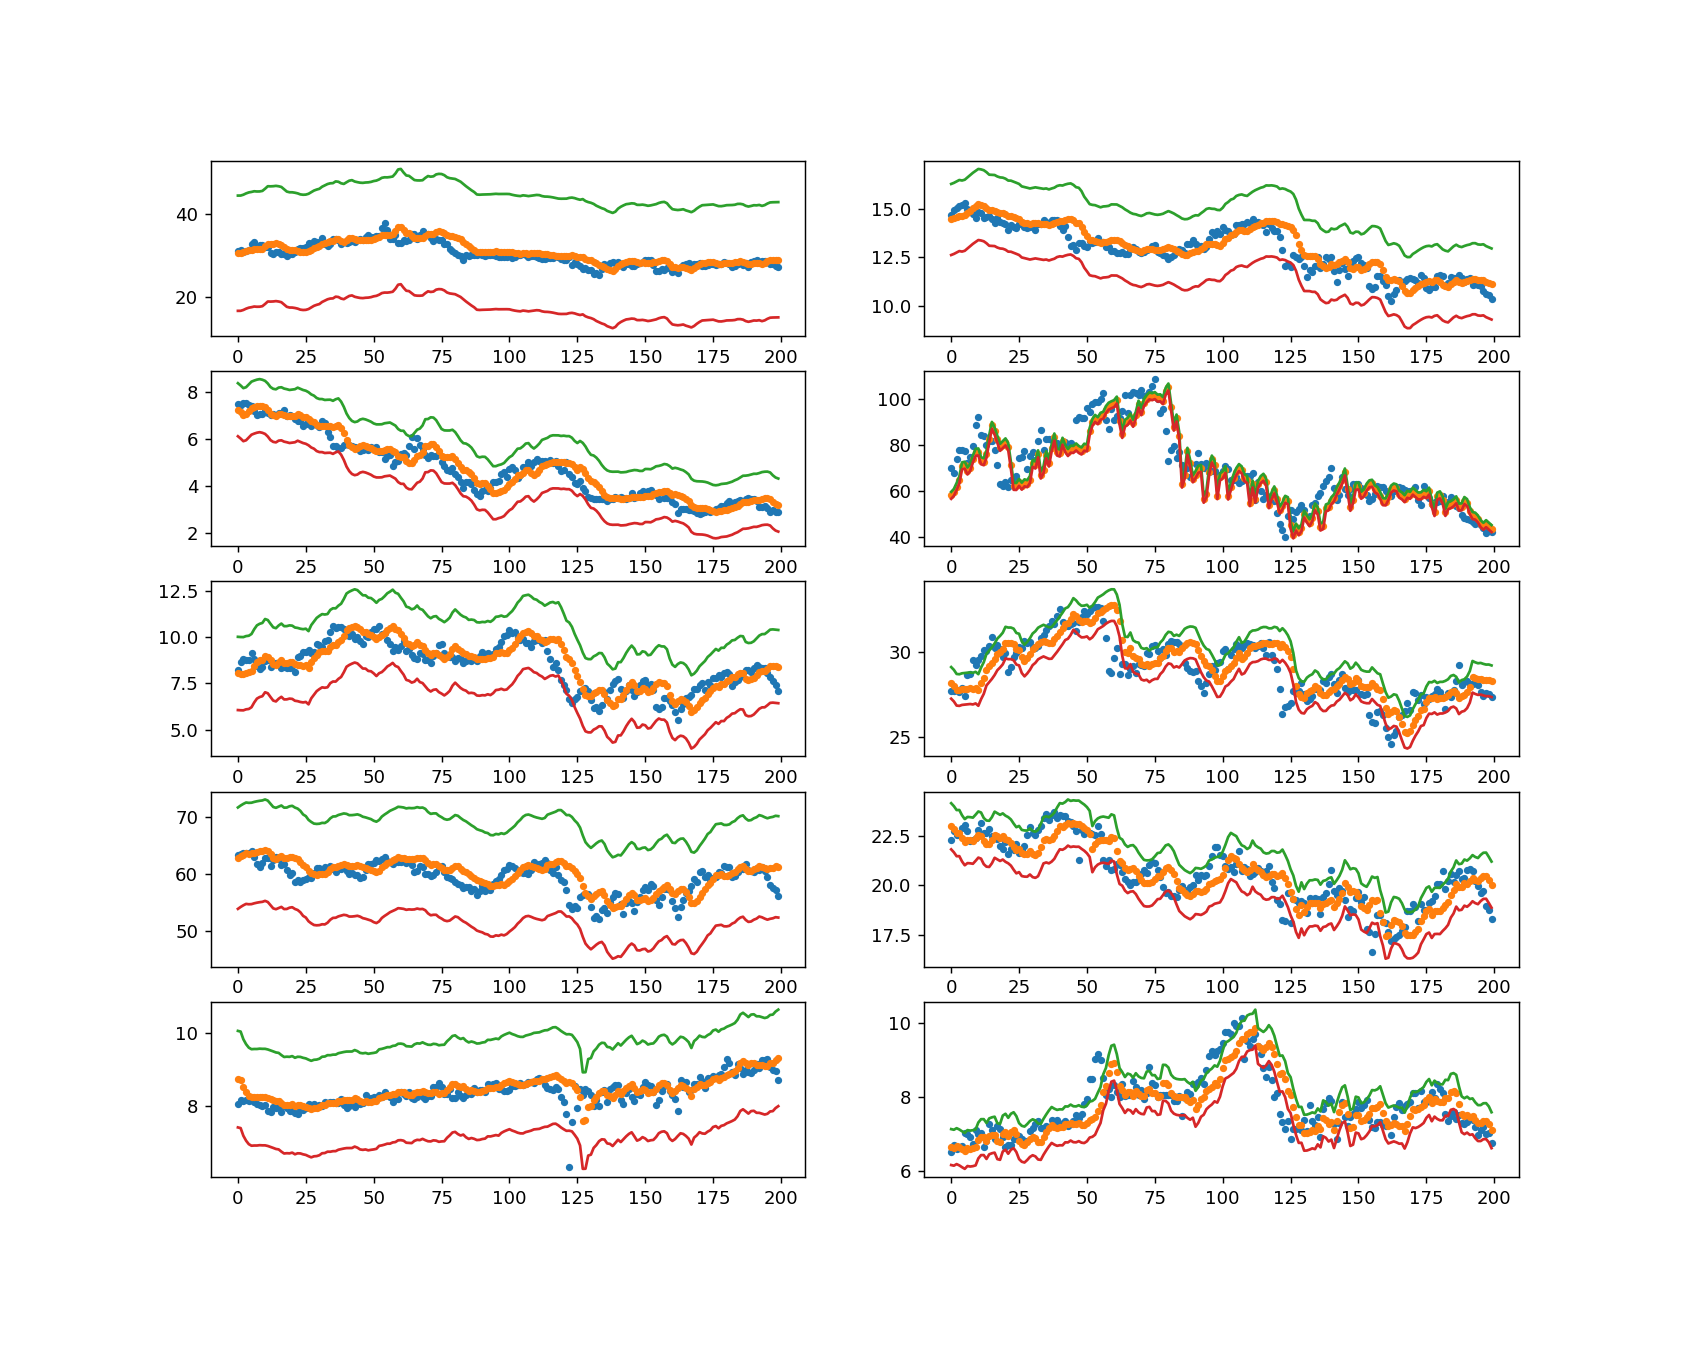

In [323]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name], prediction_dict[stock_name]['train_forecasts'], prediction_dict[stock_name]['valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)
    

In [324]:
d_select.head()

,FLT,WAFD,SORL,NAVB,TRN,DBE,IYW,AMOV,OLP,RIGL
Date,,,,,,,,,,
2010-12-23,28.91,13.78,8.61,39.0,7.10,26.03,59.08,22.69,9.19,7.78
2010-12-27,30.83,13.71,8.53,38.8,7.05,26.07,58.94,22.56,9.19,7.78
2010-12-28,30.83,13.80,8.75,39.0,7.16,26.20,59.32,22.65,9.10,7.79
2010-12-29,31.00,13.76,8.48,39.4,7.22,26.19,59.28,22.88,9.02,7.69
2010-12-30,30.71,13.81,8.42,39.6,7.22,26.10,59.19,22.82,8.87,7.70


In [325]:
for stock_name in ticker_set:
    pred = prediction_dict[stock_name]['expected_tomorrow']
    current_price = d.iloc[d.shape[0] - 1, :][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

In [326]:
rat_risks = pd.DataFrame({'return_rate':[prediction_dict[stock_name]['return_rate'] for stock_name in ticker_set],
                        'risk' : [prediction_dict[stock_name]['valid_sd'] for stock_name in ticker_set],
                         'price': d.iloc[d.shape[0] - 1][ticker_set]})

In what follows I'll be minimzing the mixed variance by selecting the "best" portfolio for a given return rate and budjet. For the optimization part I have heavily been dependent on the codes in [this tutorial](https://towardsdatascience.com/efficient-frontier-optimize-portfolio-with-scipy-57456428323e). Kudos to **J Li**. I have modified the code to compute the portfolio return rate and risk from mixture of normals distribution. Later I will also modify the optimization function by adding new constraints to compute the number of shares to buy with a given budget rather than the weight of instruments in the portfolio.

<IPython.core.display.Javascript object>


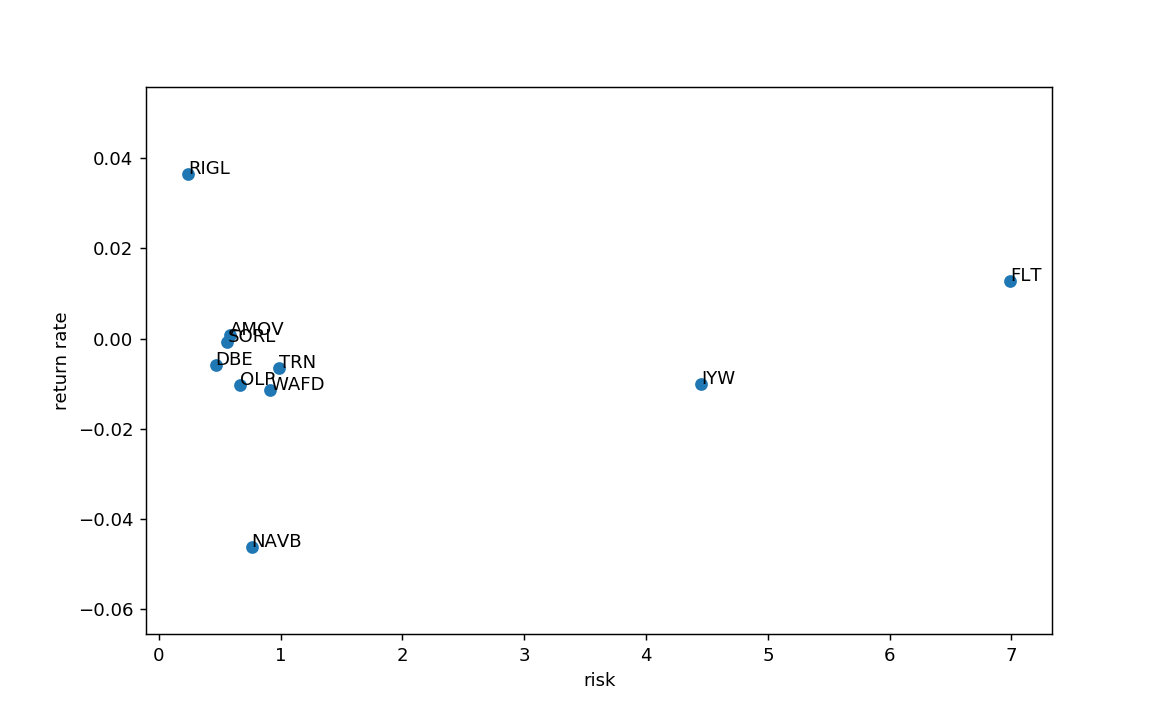

In [327]:
fig, ax = plt.subplots()
ax.scatter(rat_risks['risk'], rat_risks['return_rate'])
for stock_name in ticker_set:
    ax.annotate(stock_name, (prediction_dict[stock_name]['valid_sd'], prediction_dict[stock_name]['return_rate']))
plt.xlabel("risk")
plt.ylabel("return rate")
plt.show()

variance of a mixture of normals can be computed by the formula below: [(source)](https://stats.stackexchange.com/questions/16608/what-is-the-variance-of-the-weighted-mixture-of-two-gaussians)
<img src="ext/mixture_variance.png" style="height:200px">

In [328]:
def get_portfolio_risk(weights, rat_risks):
    first_term = np.sum(weights * (rat_risks['risk']**2))
    second_term = np.sum(weights * (rat_risks['return_rate'])**2)
    third_term = np.sum(weights * rat_risks['return_rate'])**2
    mixed_var = first_term + second_term + third_term
    return mixed_var

def get_portfolio_return(weights, rat_risks):
    total_return_rate = np.sum(rat_risks['return_rate'] * weights)
    return total_return_rate

In [329]:
def optimize_weights(rat_risks, target_return=0.1):
    instruments_count = rat_risks.shape[0]
    init_guess = np.ones(instruments_count) * (1.0 / instruments_count)
    bounds = ((0.0, 1.0),) * instruments_count
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(rat_risks,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (rat_risks,),
                                     'fun': lambda inputs, rat_risks:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          rat_risks=rat_risks)}
                                   ),
                       bounds=bounds)
    return weights.x, weights.success, weights.status

In [330]:
weights, success, status = optimize_weights(rat_risks)
print(get_portfolio_risk(results, rat_risks))
print(success)
print(status)

0.3646067209863796
False
8


<IPython.core.display.Javascript object>


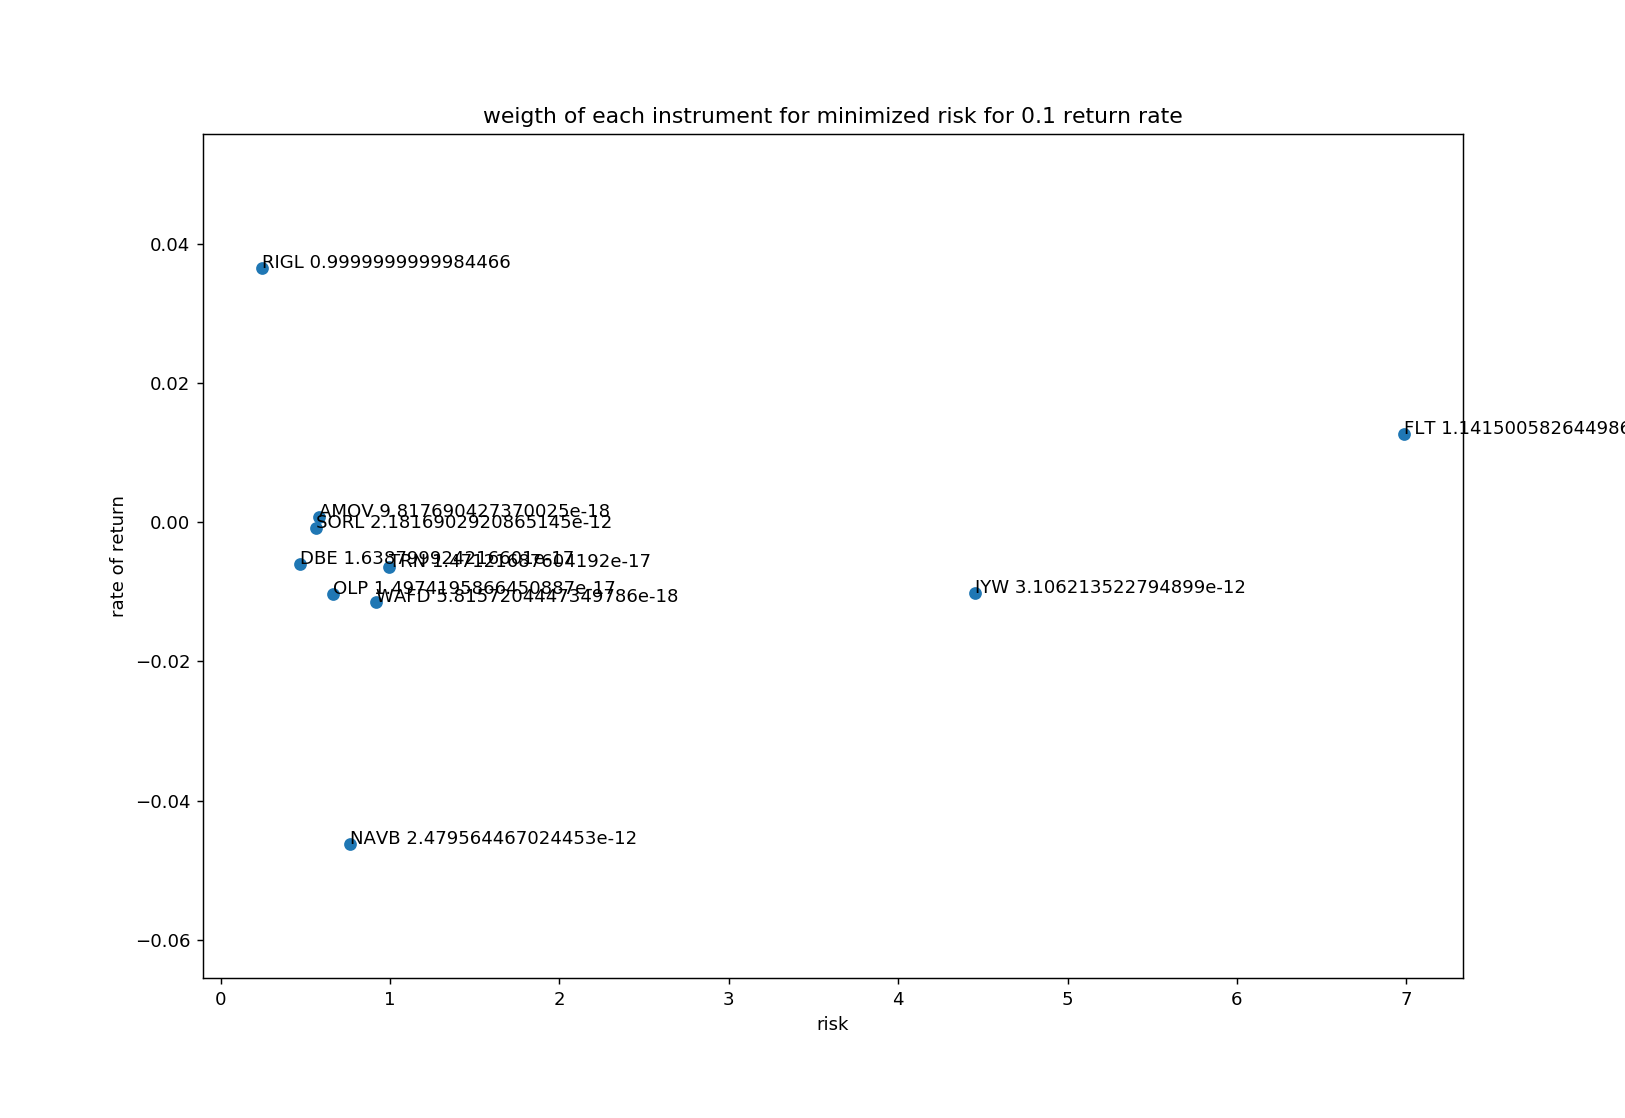

In [331]:
fig, ax = plt.subplots()
ax.scatter(rat_risks['risk'], rat_risks['return_rate'])
for i, stock_name in enumerate(ticker_set):
    ax.annotate(' '.join([stock_name, str(weights[i])]), (prediction_dict[stock_name]['valid_sd'], prediction_dict[stock_name]['return_rate']))
plt.title("weigth of each instrument for minimized risk for 0.1 return rate")
plt.xlabel("risk")
plt.ylabel("rate of return")
plt.show()

The weights seem to make sense, with the instruments with higher risk getting a weight of zero and the ones with higher return rate and small risk getting the largest of weights. 
Now let's modify the optimization function to accept and budget constraint as well as output number of shares per instrument (integer) rather than weights.

In [332]:
def get_portfolio_risk_by_shares(shares, rat_risks):
    weights = shares / np.sum(shares)
    first_term = np.sum(weights * (rat_risks['risk']**2))
    second_term = np.sum(weights * (rat_risks['return_rate'])**2)
    third_term = np.sum(weights * rat_risks['return_rate'])**2
    mixed_var = first_term + second_term + third_term
    return mixed_var

def get_portfolio_return_by_shares(shares, rat_risks, budget):
    spent = np.sum(rat_risks['price'] * shares)
    unspent = budget - spent
    returns = spent * np.sum(rat_risks['return_rate'] * shares) + unspent
    total_return_rate = (returns/budget) - 1
    return total_return_rate

def budget_constraint(shares, rat_risks, budget):
    prices = np.array(rat_risks['price'])
    unspent = budget - np.sum(shares * prices)
    return(unspent)

In [340]:
def optimize_shares(rat_risks, target_return=0.1, budget = 2000):
    #normalized_prices = prices / prices.ix[0, :]
    instruments_count = rat_risks.shape[0]
    init_guess = np.ones(instruments_count) * 2 #(1.0 / instruments_count)
    bounds = ((0.0, np.inf),) * instruments_count
    shares = minimize(get_portfolio_risk_by_shares, init_guess,
                       args=(rat_risks,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'ineq', 'fun': lambda x: budget_constraint(x, rat_risks, budget)}, #make sure total is less than budget
                                    {'type': 'eq', 'args': (rat_risks, budget), #make the return rate equal to the expected rate
                                     'fun': lambda inputs, rat_risks, budget:
                                     target_return - get_portfolio_return_by_shares(inputs, rat_risks, budget)},
                                    {'type':'eq','fun': lambda x : max([0] + [x[i]-int(x[i]) for i in range(len(x)) if x[i]-int(x[i]) > 0])}, #try to make them as close to integer as possible
                                   ),
                       bounds=bounds
                     )
    return shares.x, shares.success, shares.status, shares.message

In [341]:
budget = 2000
share_distribution, success, status, message = optimize_shares(rat_risks, budget = budget)
share_distribution
output = rat_risks
output['shares'] = np.floor(share_distribution)

In [342]:
message

'Iteration limit exceeded'

In [343]:
print(' '.join(['retrun rate', str(get_portfolio_return_by_shares(rat_risks['shares'], rat_risks, budget))]))
print(' '.join(['risk', str(get_portfolio_risk_by_shares(rat_risks['shares'], rat_risks))]))
print(' '.join(['invested:', str(np.sum(rat_risks['shares'] * rat_risks['price']))]))

retrun rate 0.07809738297602853
risk 0.1054198977307532
invested: 160.51


In [346]:
share_distribution

array([2.18945165e-03, 2.11658743e-01, 2.91701257e-01, 3.18878559e+00,
       1.22016831e+00, 2.21626124e-01, 9.04716596e-02, 1.05709583e+00,
       2.85704014e-01, 5.80696577e+01])

In [347]:
rat_risks

,return_rate,risk,price,shares
FLT,0.012725,6.987181,290.45,0.0
WAFD,-0.011394,0.915236,37.75,0.0
SORL,-0.000868,0.563291,4.44,0.0
NAVB,-0.046223,0.761504,1.02,3.0
TRN,-0.006449,0.990756,22.75,1.0
DBE,-0.005927,0.467805,14.89,0.0
IYW,-0.010180,4.451294,231.44,0.0
AMOV,0.000727,0.581185,15.80,1.0
OLP,-0.010329,0.663767,27.71,0.0
RIGL,0.036509,0.243426,2.05,58.0


In [43]:
#funnction copied from matplotlib gallery
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [350]:
list(d.index.values)[-1]


,A,AA,AADR,AAL,AAME,AAN,AAON,AAP,AAPL,AAT,...,ZIOP,ZIV,ZIXI,ZN,ZNH,ZROZ,ZSL,ZTR,ZUMZ,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-16,84.47,20.99,52.90,27.62,1.77,59.22,50.40,155.41,277.00,44.73,...,4.95,72.68,6.63,0.16,34.00,138.20,29.63,11.00,32.14,9.31
2019-12-17,84.76,20.82,53.34,27.97,1.80,59.54,49.26,154.45,279.57,45.00,...,5.04,72.98,6.55,0.14,34.58,137.94,29.49,11.06,31.48,9.40
2019-12-18,83.75,20.60,53.17,28.35,1.83,60.06,50.00,158.07,279.80,44.44,...,4.93,72.06,6.51,0.13,34.38,136.65,29.77,11.05,31.46,8.68
2019-12-19,83.95,21.10,53.21,28.00,1.87,59.13,49.88,157.47,279.50,44.68,...,4.95,72.52,6.46,0.14,33.90,135.51,29.62,11.13,32.49,8.39
2019-12-20,84.94,21.58,53.40,28.67,2.01,59.34,49.35,157.77,282.23,44.98,...,5.17,72.91,6.72,0.18,33.83,135.49,28.86,11.20,32.24,7.95


In [44]:
covars

,FLT,WAFD,SORL,NAVB,TRN,DBE,IYW,AMOV,OLP,RIGL
FLT,5237.231496,494.029412,4.986575,-1550.674010,317.817562,-382.413270,3158.564243,-133.187457,387.881112,-136.307916
WAFD,494.029412,58.531584,3.059908,-163.970099,30.957062,-42.196770,334.963628,-13.860299,39.578118,-12.494651
SORL,4.986575,3.059908,2.193043,-3.464408,1.999206,0.437986,13.095369,1.299453,0.370297,0.019722
NAVB,-1550.674010,-163.970099,-3.464408,597.427219,-105.464341,141.927949,-982.136218,50.864758,-122.065494,46.511435
TRN,317.817562,30.957062,1.999206,-105.464341,35.389796,-17.533945,188.736895,-5.489289,22.854104,-9.956857
DBE,-382.413270,-42.196770,0.437986,141.927949,-17.533945,53.458810,-238.582697,17.017998,-31.153135,11.814976
IYW,3158.564243,334.963628,13.095369,-982.136218,188.736895,-238.582697,2180.941707,-72.425651,251.864558,-69.151132
AMOV,-133.187457,-13.860299,1.299453,50.864758,-5.489289,17.017998,-72.425651,9.422551,-11.128204,4.821665
OLP,387.881112,39.578118,0.370297,-122.065494,22.854104,-31.153135,251.864558,-11.128204,31.734795,-9.719825
RIGL,-136.307916,-12.494651,0.019722,46.511435,-9.956857,11.814976,-69.151132,4.821665,-9.719825,5.718475


In [298]:
rat_risks.head(10)

,return_rate,risk,price,shares
FLT,-0.015952,3.713364,290.45,0.0
WAFD,-0.000524,0.558968,37.75,0.0
SORL,0.000865,0.260685,4.44,0.0
NAVB,0.141385,0.474379,1.02,27.0
TRN,-0.002674,0.521636,22.75,0.0
DBE,-0.005051,0.232475,14.89,0.0
IYW,-0.009711,2.669656,231.44,0.0
AMOV,0.000924,0.336110,15.80,0.0
OLP,-0.034187,0.620849,27.71,0.0
RIGL,0.042193,0.142890,2.05,6.0


Some of the stock data have a lot of missing points over the past 9 years. This might be because they were founded later or had their IPO sometime during this time-period. Below I take a look at the number of stocks with various numbers of missing points and filter the data to the ones with less than 20 NA's. I will impute the missing points by "backward filling".

Alright, now we have the data and for each stock we can take a look at their trend. Change the *ticker_name* below and have a look at the plot. I'm plotting the Microsoft stock prices from some day in December 2012 up to December 2019.

In [ ]:
ticker_name = "MSFT"
import matplotlib.pyplot as plt
plt.plot(d[ticker_name])

In [ ]:
# this function is copied exactly from the deeplearning.ai course on time-series analysis on coursera!
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[0].reshape((len(window[0], 1))), window[1]))
    else:
        dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
stock_name = "MSFT"
weekly = False

In [ ]:
#d = d.iloc[:, :1]#:int(d.shape[1]/2)]
d = d.loc[:,[stock_name]]
d.describe()

In [ ]:
if weekly:
    d.reset_index(drop = False, inplace = True)
    d['weekday'] = d['Date'].dt.day_name()
    d = d[d['weekday'] == "Friday"]
    d.drop(['Date', 'weekday'], axis = 1, inplace = True)
    print(d.shape)
    print(d.head())
    d.reset_index(drop = True, inplace = True)

In [158]:
rat_risks.describe()

,return_rate,risk,price
count,10.000000,10.000000,10.000000
mean,0.011727,0.953101,64.830000
std,0.049382,1.214841,104.935517
min,-0.034187,0.142890,1.020000
25%,-0.008546,0.279541,7.052500
50%,-0.001599,0.498007,19.275000
75%,0.000909,0.605379,35.240000
max,0.141385,3.713364,290.450000


In [ ]:
p = d.reset_index(drop = True)
plt.plot(p[stock_name])

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer = 100000
training_points = 350 if weekly else 1500

In [ ]:
#d = d / train_d.max(axis = 0)
train_d = d.iloc[:training_points, :]
valid_d = d.iloc[training_points:, :]
train_df = windowed_dataset(train_d.to_numpy().reshape((len(train_d,))), window_size, batch_size, shuffle_buffer)
normalization_factors = train_d.max()
valid_df = windowed_dataset(valid_d.to_numpy().reshape((len(valid_d,))), window_size, batch_size, shuffle_buffer, shuffle = False)

In [ ]:
train_df
valid_df

In [ ]:
#td = windowed_dataset(np.array(train_d['MSFT']), window_size, batch_size, shuffle_buffer)
#td

In [ ]:
#train_y = train_d[30:]
#train_y.shape
train_d[stock_name].shape
train_d.shape

In [ ]:
train_d.describe()
valid_d.describe()

In [ ]:
def layer_normalize(x, factors = None, denorm = False, input_mean = None, input_std = None):
    if factors is None:
        factors = tf.reduce_max(x, axis = 0, keepdims = False)
        #tf.print(factors)
        tf.print("pre mod shape of x")
        tf.print(tf.shape(x))
        tf.print("shape of factors")
        tf.print(tf.shape(factors))
    input_mean = tf.math.reduce_mean(x, axis = 0)
    input_std = tf.keras.backend.std(x)
    if denorm:
        #x += 1
        factors = 1. / factors
    x /= factors
    '''
    if not denorm:
        if len(x.get_shape()) == 3:
            #tf.print('mean', input_mean)
            #tf.print('std')
            #tf.print('std', input_std)
            #tf.print('oldx')
            #tf.print('shape',x.get_shape())
            #tf.print(x)
            x = (x - input_mean)/input_std
    else:
        #tf.print('mean')       
        #tf.print(len(x.get_shape()))
        x = x * input_std + input_mean
    '''
    #x = (x - tf.keras.backend.mean(x)) / tf.keras.backend.std(x)
    #tf.print("post mod shape of x")
    #tf.print(tf.shape(x))
    return x

In [ ]:
distributional = False
tf.compat.v1.reset_default_graph()
#output_size = train_d.shape[1]
tfd = tfp.distributions
output_dense_size = 2 if distributional else 1

def activations(l, input_mean = None, input_std = None, window_size = None):
    l_0 = (tf.keras.activations.linear(l[...,0])) * input_mean #* input_std) + input_mean #* normalization_factors
    #l_1 = std_multiplier + 
    l_1 = ((tf.keras.activations.linear(tf.abs(l[...,1])))) + 1e-6 # * input_std + input_mean) / window_size) / 0.5
    #tf.print(l_1)
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

def simple_activations(l):
    l_0 = tf.keras.activations.linear(l[...,0])
    l_1 = tf.keras.activations.elu(l[...,1])
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

initializers = "glorot_normal"
activation_name = 'relu'
model = tf.keras.models.Sequential([
  #tf.keras.layers.LayerNormalization(axis = 0),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : False}, input_shape = (window_size,)),
  #tf.keras.layers.GRU(32, return_sequences = True, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)), 
  #tf.keras.layers.Conv1D(128, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(pool_size = 3, padding = 'valid'),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.1),
  #tf.keras.layers.GRU(8, return_sequences=True, kernel_initializer = initializers),
  tf.keras.layers.GRU(64, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)),
  #tf.keras.layers.LSTM(32, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.Dense(output_dense_size, activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)), kernel_initializer = "he_normal"),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}),
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=tf.abs(t[..., 0]), scale=0.01*(tf.abs(t[..., 1]))))#-t[...,0]))))#t[...,1])) 
  #                         #scale=(tf.keras.backend.std[...,1])))
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,0], scale = t[...,0] + tf.keras.backend.std(t[:,1])))
  #                         #scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
  #tfp.layers.IndependentNormal(output_size)
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

if distributional:
    model.add(tf.keras.layers.Dense(
        output_dense_size, activation = 'linear',
        #activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)),
        #activation = tf.keras.layers.Activation(lambda x: simple_activations(x)),
        kernel_initializer = "he_uniform"))
    model.add(tfp.layers.DistributionLambda(lambda t: 
                                            tfd.Normal(
                                                loc=tf.abs(t[..., 0]), 
                                                scale= 1e-6 + tf.abs(t[..., 1]) #* normalization_factors
                                            )))
else: 
    #model.add(tf.keras.layers.Dense(128, activation = 'linear'))
    model.add(tf.keras.layers.Dense(1, activation = 'linear', kernel_initializer = initializers))
    #model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : True}))
#model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}))
    
negloglik = lambda y, p_y: -p_y.log_prob(y)
#negcheck = lambda y, yh: tf.math.abs(y - yh[:,0])
#optimizer = tf.keras.optimizers.Adam()#.minimize(cost)
#model.compile(#loss=tf.keras.losses.Huber(),
#              loss=negloglik,
#              #loss = 'mse',
#              #loss = cost,
#              optimizer=optimizer,
#              #optimizer = 'Adam',
#              metrics = ['mae']
#             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
#history = model.fit(train_df, epochs=10, validation_data = valid_df)

loss_function = negloglik if distributional else 'mse' #tf.keras.losses.Huber()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
model.fit(train_df, epochs=20, verbose=True, validation_data = valid_df)

In [ ]:
xh = model.predict(train_df)
forecasts_x = []
sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(train_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(train_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts_x.append(prediction)
    sds.append(prediction - vs[time+window_size])
sd_estimate = np.sqrt(np.sum(np.array(sds)**2) / (training_points - window_size - 1))
forecasts_x = np.array(forecasts_x)[:,0].reshape((training_points - window_size))

In [ ]:
limit_begin = 150
limit_end = 300
plt.plot(np.array(train_d[(window_size + limit_begin): (window_size + limit_end)]), '.')
plt.plot(forecasts_x[limit_begin:limit_end], '.')
plt.plot(forecasts_x[limit_begin:limit_end] + 2*sd_estimate, '-')
plt.plot(forecasts_x[limit_begin:limit_end] - 2*sd_estimate, '-')

In [ ]:
tomorrows_prediction = model.predict(np.array(d[stock_name])[-window_size:].reshape(1, window_size, 1))[0, 0]
tomorrows_prediction

In [ ]:
training_points - window_size

In [ ]:
print(xh[:10])
print(train_d[window_size:window_size + 10])
print((xh - np.array(train_d[window_size:]))[:10])

In [ ]:
forecasts = []
#sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(valid_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(valid_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts.append(prediction)
    sds.append(vs[time+window_size] - prediction)
    #forecasts.append(model(vs[time:time+window_size].reshape((1, window_size, 1))))
#print(vs[:window_size])
#print(forecasts)

In [ ]:
print(len(forecasts))
forecasts[1]
if distributional:
    ymeans = np.array([i.mean() for i in forecasts])
    ystdv = np.array([i.stddev() for i in forecasts])
else:
    forecasts = np.array(forecasts[:,0,0])
    sds = np.array(sds)[:,0,0]
forecasts
sd_estimate = np.sqrt(np.sum(sds ** 2)/(sds.shape[0]-1))
sd_estimate

In [ ]:
sds.shape[0]

In [ ]:
forecasts[0].shape
results = np.array(forecasts)[:, 0]
np.max(results)

In [ ]:
plt.plot(np.array(valid_d)[window_size + 100: window_size + 150], '.', label = 'obs')
plt.plot(forecasts[100:150], '.', label = 'pred')
plt.plot(forecasts[100:150] + sd_estimate, '-')
plt.plot(forecasts[100:150] - sd_estimate, '-')
plt.legend()

## draftpad: (nothing interesting below)

In [ ]:
train_df

In [ ]:
x = np.zeros(shape = (batch_size, window_size))
y = np.zeros(shape = (batch_size, 1))
for i, j in valid_df:
    x = i
    y = j
    break

In [ ]:
print(x.shape, y.shape, distributional)

In [ ]:
if (distributional):
    ys = model(x)
    yhat = ys.mean()
    ydev = ys.stddev()
else:
    #ys = pd.DataFrame(model.predict(x))
    ys = model.predict(x)

In [ ]:
ys.shape

In [ ]:
plt.plot(y, '.', label = 'obs')
if distributional:
    plt.plot(yhat, 'r.', label = 'pred')
    plt.plot(yhat + 2*ydev, '-')
    plt.plot(yhat - 2*ydev, '-')
else:
    plt.plot(ys[:50, 0], '.', label = 'pred')
plt.legend()

In [ ]:
ys.shape

In [ ]:
ts = vs[:30].reshape((1, 30))
ts.shape
model.predict(ts)

In [ ]:
vs[time:time+window_size].reshape((window_size))

In [ ]:
plt.plot(y, 'b.')
plt.plot(model(x)[:,0], 'r.')
plt.plot(model(x)[:,0] + model(x)[:,1], '-')

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
yhat = model.predict(valid_df)

In [ ]:
mean = yhat.mean()
stddev = yhat.std()
mean_plus_2_stddev = mean - 2. * stddev
mean_minus_2_stddev = mean + 2. * stddev
#plt.plot(mean)#, 'o')
plt.plot(yhat, '.')
plt.plot(vd*normalization_factors + mean_plus_2_stddev, '-')

In [ ]:
vd = valid_d.reset_index(drop = True)
normalization_factors

In [ ]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

Since I'm trying to output mean and variance for each stock, I will need two units in my output layer and each will most likely require a different activation function. This can be done [at least more neatly] in funnctional API of keras.

In [ ]:
output_size = train_d.shape[1]
variables = train_d.shape[1]
#output_size = 1
print(output_size)
inputs = tf.keras.Input(shape=(None, variables))
normalization_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False})(inputs)
output_1 = tf.keras.layers.LSTM(128, return_sequences=True)(normalization_layer)
output_2 = tf.keras.layers.LSTM(256, return_sequences=True)(output_1)
output_3 = tf.keras.layers.LSTM(256, return_sequences=True)(output_2)
output_4 = tf.keras.layers.LSTM(128, return_sequences=False)(output_3)
#predictions = tf.keras.layers.Dense(1, activation='elu')(output_4)

#sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
#relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
#out = tf.concat([sigmoid_out, relu_out], axis=1)

#denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(predictions)

mu = tf.keras.layers.Dense(units=1, activation = 'elu')(output_4)
sigma = tf.keras.layers.Dense(units=1,activation=lambda x: tf.nn.elu(x) + 1)(output_4)

mu_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(mu)
sigma_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(sigma)

out = tf.concat([sigma_denorm, mu_denorm], axis=1)

model = tf.keras.Model(inputs=inputs, outputs=out)

'''
sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
out = tf.concat([sigmoid_out, relu_out], axis=1)
inner_layers.add(out)

denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})

inner_layers.add(denorm_layer)
model = inner_layers

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
'''
cost = mdn_cost(mu_denorm, sigma_denorm, y)
optimizer = tf.keras.optimizers.Adam().minimize(cost)
model.compile(#loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              loss = cost,
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
output_size = train_d.shape[1]
#output_size = 1
print(output_size)
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), #if the input is one stock
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  #tf.keras.layers.Conv1D(128, kernel_size = 3, input_shape = (batch_size, window_size, None)),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1, activation = 'relu'),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.GRU(512, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256),
  #tf.keras.layers.SimpleRNN(128, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, activation = 'tanh', return_sequences=True),
  #tf.keras.layers.LSTM(128),
  #tf.keras.layers.SimpleRNN(64, return_sequences = True),
  #tf.keras.layers.SimpleRNN(128, return_sequences = True),
  #tf.keras.layers.SimpleRNN(256),
  tf.keras.layers.Dense(output_size, activation = 'elu'),
  #tf.keras.layers.Lambda(lambda x: x + 1),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
d.to_numpy()[50:55, :8]
train_d.describe()

In [ ]:
#p = model.predict(np.array(d['MSFT']).reshape((len(d['MSFT']), 1)))
p = model.predict(train_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
p = pd.DataFrame(p)
p2 = p #* d.max(axis = 0).reset_index(drop = True)
p2.describe()

In [ ]:
### MDN MODEL

N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(1, activation = 'elu'),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])

model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=tf.keras.optimizers.Adam())
#model(train_df)
#model.summary()
history = model.fit(train_df, epochs=10)
p = model.predict(train_df)
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, p, OUTPUT_DIMS, N_MIXES, temp=1.0)

In [ ]:
s = pd.DataFrame({'s' : y_samples[:, 0, 0] * normalization_factors[0]})
s.describe()
#normalization_factors

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
print(valid_d.describe())
print(train_d.describe())

In [ ]:
valid_d.tail()

In [ ]:
p2 = model.predict(df)
pd.DataFrame(p2).describe()

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 130000, 170000])

In [ ]:
np.where(d.columns.values == "MSFT")

In [ ]:
p[:, 2572].max()

In [ ]:
t.tickers[0].info

In [ ]:
t = yf.Tickers(' '.join(list(tickers.keys())))

In [ ]:
#df = t.history(period="9y", interval = '1d')
?Tickers.history

In [ ]:
yf.Tickers.history

In [ ]:
t.history(period="9y", interval = '1d', 'Open')

In [ ]:
import mdn

In [ ]:
!pip3 install keras-mdn-layer

In [ ]:
import sys
print(sys.version)

In [ ]:
import mdn

In [ ]:
d

In [155]:
d.iloc[d.shape[0] - 1][ticker_set]

FLT     290.45
WAFD     37.75
SORL      4.44
NAVB      1.02
TRN      22.75
DBE      14.89
IYW     231.44
AMOV     15.80
OLP      27.71
RIGL      2.05
Name: 2019-12-20 00:00:00, dtype: float64

In [156]:
ticker_set

['FLT', 'WAFD', 'SORL', 'NAVB', 'TRN', 'DBE', 'IYW', 'AMOV', 'OLP', 'RIGL']

In [351]:
msft = yf.Ticker("MSFT")
temp_hist = msft.history(period="9y", interval="1d")

In [383]:
ld = d.index.values[-1]
print(ld)
p = pd.to_datetime([ld])
p = p.strftime("%Y-%m-%d")
p.values[0]
#pd.DatetimeIndex(np.datetime_as_string(ld))
last_date = (pd.to_datetime(d.index.values[-1])).strftime("%Y-%m-%d")
print(last_date)

2019-12-20T00:00:00.000000000
2019-12-20


In [384]:
h = msft.history(start = last_date, interval='1d')


In [385]:
h.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-20,157.35,158.49,156.29,157.41,53477500,0,0
2019-12-23,158.12,158.12,157.27,157.41,17718200,0,0
2019-12-24,157.48,157.71,157.12,157.38,8989200,0,0
2019-12-26,157.56,158.73,157.40,158.67,14520600,0,0
2019-12-27,159.45,159.55,158.22,158.96,18412800,0,0


A
AA
AADR
AAL
AAME
AAN
AAON
AAP
AAPL
AAT
AAU
AAWW
AAXJ
AAXN
AB
ABB
ABC
ABCB
ABEO
ABEV
ABG
ABIO
ABM
ABMD
ABR
ABT
ABUS
AC
ACAD
ACB
ACC
ACCO
ACER
ACH
ACHC
ACHN
ACHV
ACIW
ACLS
ACM
ACN
ACNB
ACOR
ACTG
ACU
ACWI
ACWX
ACY
ADBE
ADC
ADES
ADI
ADM
ADMP
ADP
ADRA
ADRD
ADRE
ADRU
ADS
ADSK
ADTN
ADUS
ADX
ADXS
AE
AEE
AEF
AEG
AEGN
AEHR
AEIS
AEL
AEM
AEMD
AEO
AEP
AER
AES
AEY
AEZS
AFB
AFC
AFG
AFK
AFL
AG
AGCO
AGD
AGEN
AGG
AGI
AGM
AGN
AGNC
AGO
AGQ
AGX
AGYS
AGZ
AHC
AHPI
AHT
AI
AIA
AIG
AIM
AIMC
AIN
AINV
AIR
AIRI
AIRT
AIT
AIV
AIZ
AJG
AJRD
AKAM
AKG
AKR
AKRX
AKS
ALB
ALBO
ALCO
ALE
ALG
ALGN
ALGT
ALIM
ALJJ
ALK
ALKS
ALL
ALLT
ALNY
ALO
ALOT
ALRS
ALSK
ALT
ALV
ALX
ALXN
ALYA
AMAG
AMAT
AMD
AME
AMED
AMEH
AMG
AMGN
AMJ
AMKR
AMLP
AMN
AMNB
AMOT
AMOV
AMP
AMPE
AMRB
AMRC
AMRN
AMRS
AMS
AMSC
AMSF
AMSWA
AMT
AMTD
AMWD
AMX
AMZN
AN
ANAT
ANDE
ANF
ANGO
ANH
ANIK
ANIP
ANIX
ANSS
ANTE
ANTM
AOA
AOBC
AOD
AOK
AOM
AON
AOR
AOS
AOSL
AP
APA
APD
APDN
APEI
APEN
APEX
APH
APOG
APPS
APT
APTO
APWC
AQN
ARA
ARAY
ARC
ARCB
ARCC
ARE
ARGO
ARI
ARKR
ARL
ARLP
ARMP
AR

ValueError: cannot reindex from a duplicate axis

In [397]:
d_update

NameError: name 'd_update' is not defined

In [405]:
hist = tickers['BKJ']['ticker'].history(start = last_date, interval = "1d")[['Open']]

In [404]:
hist.drop_duplicates()

,Open
Date,
2019-12-20,19.02
2019-12-23,19.49
2019-12-24,19.52
2019-12-26,19.64
2019-12-27,19.26
2019-12-30,19.10


In [406]:
hist

,Open
Date,
2019-12-20,19.02
2019-12-23,19.49
2019-12-24,19.52
2019-12-26,19.64
2019-12-27,19.26
2019-12-30,19.10
2019-12-31,19.02
2019-12-31,19.02


In [410]:
h2 = hist.drop_duplicates(keep = 'last')

In [411]:
h2

,Open
Date,
2019-12-23,19.49
2019-12-24,19.52
2019-12-26,19.64
2019-12-27,19.26
2019-12-30,19.10
2019-12-31,19.02
